#Prétraitement des données Images

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dossier contenant les images
IMAGE_DIR = "./Flipkart/Images/"  

# Chargement des images
def load_images(image_dir):
    images = []
    filenames = []
    for file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            filenames.append(file)
    return images, filenames



In [ ]:
# Chargement de la liste des images
from os import listdir

list_photos = [file for file in listdir(IMAGE_DIR)]
print(len(list_photos))

1050


In [4]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

In [5]:
# Import du DF déjà clean

data = pd.read_csv("data_cleaned.csv")

In [6]:
images, filenames = load_images(IMAGE_DIR)

Home Furnishing 


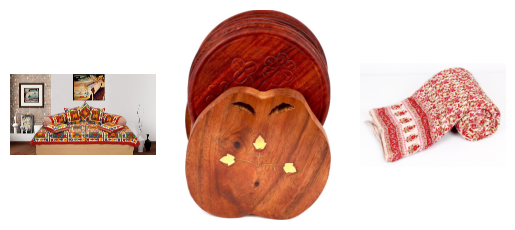

Baby Care 


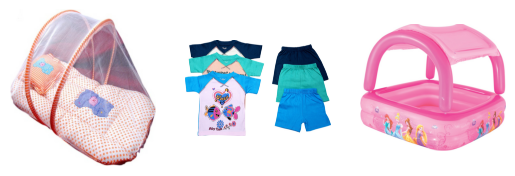

Watches 


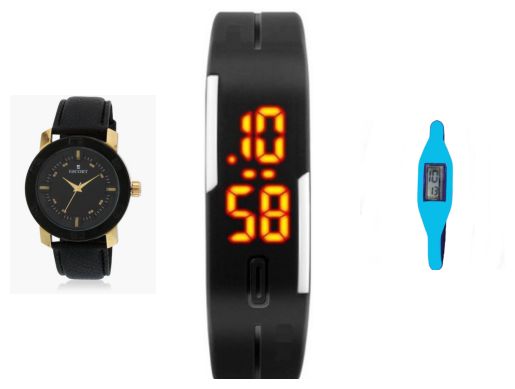

Home Decor & Festive Needs 


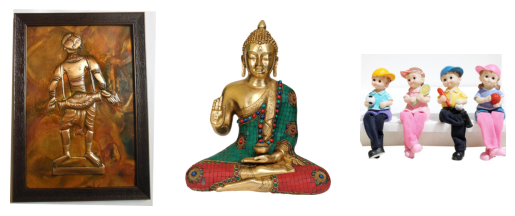

Kitchen & Dining 


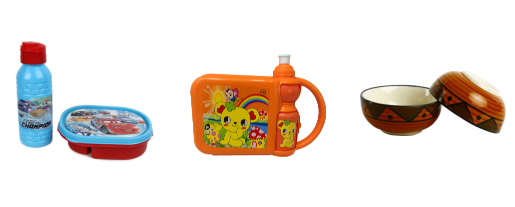

Beauty and Personal Care 


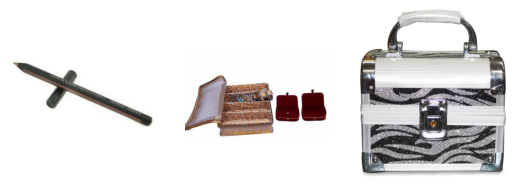

Computers 


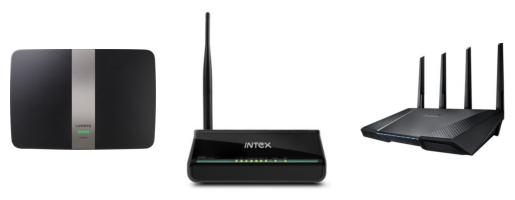

In [7]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.image import imread

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["catA"])

# Fonction pour obtenir une liste d'images par catégorie
def list_fct(name):
    return data.loc[data["catA"] == name, "image"].tolist()

# Création de variables dynamiques stockant les images par catégorie
category_names = data["catA"].unique()
category_images = {categ: list_fct(categ) for categ in category_names}

# Affichage d'un échantillon d'images par catégorie
for name in category_names:
    print(name)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        filename = IMAGE_DIR + category_images[name][i+10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis("off")
    plt.show()


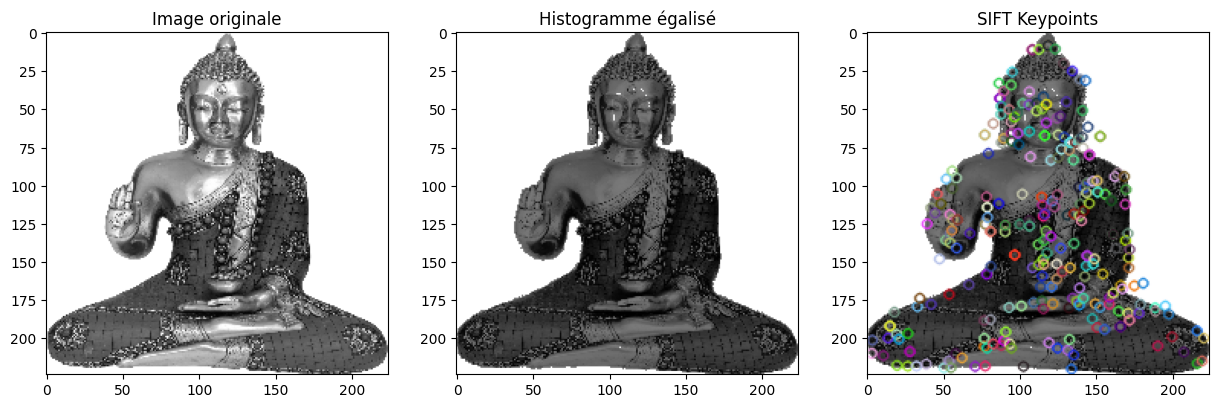

In [8]:
import random

# Initialisation de SIFT
sift = cv2.SIFT_create()

# Chargement et prétraitement de l'image
image_path = IMAGE_DIR + list_photos[random.randint(0, 1049)]  # Assurez-vous que 'path' et 'list_photos' sont définis
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (224, 224))

# Affichage de l'image originale
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title("Image originale")

# Égalisation de l'histogramme
image_eq = cv2.equalizeHist(image)

plt.subplot(132)
plt.imshow(image_eq, cmap='gray')
plt.title("Histogramme égalisé")

# Détection des keypoints SIFT
keypoints, descriptors = sift.detectAndCompute(image_eq, None)
image_sift = cv2.drawKeypoints(image_eq, keypoints, None)

plt.subplot(133)
plt.imshow(image_sift, cmap='gray')
plt.title("SIFT Keypoints")

plt.show()


In [9]:
import warnings
from tqdm import tqdm
from PIL import Image

# Ignorer les avertissements liés à la décompression d'images
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Initialisation de SIFT
sift = cv2.SIFT_create()

sift_keypoints = []
start_time = time.time()

# Extraction des features SIFT pour chaque image
for image_num in tqdm(range(len(data["image"])), desc="Processing Images"):
    image_path = IMAGE_DIR + data["image"][image_num]
    
    # Chargement et prétraitement de l'image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (299, 299))
    image_eq = cv2.equalizeHist(image)  # Égalisation de l'histogramme
    
    # Détection des keypoints et extraction des descripteurs
    keypoints, descriptors = sift.detectAndCompute(image_eq, None)
    
    # Gestion des cas où aucun descripteur n'est extrait
    if descriptors is not None:
        sift_keypoints.append(descriptors)

# Conversion en tableaux NumPy
if sift_keypoints:
    sift_keypoints_by_img = np.array(sift_keypoints, dtype=object)
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
    print(f"\nNombre de descripteurs : {sift_keypoints_all.shape}")
else:
    print("\nAucun descripteur SIFT détecté.")

# Affichage du temps de traitement
duration = time.time() - start_time
print(f"Temps de traitement SIFT descriptor : {duration:.2f} secondes")

Processing Images: 100%|██████████| 1050/1050 [00:28<00:00, 36.55it/s]



Nombre de descripteurs : (550948, 128)
Temps de traitement SIFT descriptor : 29.81 secondes


In [10]:
from sklearn import cluster, metrics


# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  742
Création de 742 clusters de descripteurs ...


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


temps de traitement kmeans :             8.16 secondes


In [11]:
# Creation of histograms
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms (features)
temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(tqdm(sift_keypoints_by_img)):
    #if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

100%|██████████| 1050/1050 [00:02<00:00, 352.39it/s]


temps de création histogrammes :             2.99 secondes


In [13]:
# kmeans

ARI_results = np.empty(shape=[0, 3])

ARI, labels = kmeans_fct(im_features, data['catA'])

ARI_results = np.append(ARI_results, [["SIFT", "None", ARI]], axis=0)

ARI :  0.0271


In [15]:
# PCA + kmeans

from sklearn.decomposition import PCA
pca = PCA(n_components=.99, random_state=22)
pca.fit(im_features)
x = pca.transform(im_features)

print(f"Components before PCA: {im_features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data['catA'])

ARI_results = np.append(ARI_results, [["SIFT", "PCA", ARI]], axis=0)

Components before PCA: 742
Components after PCA: 559
ARI :  0.0277


ARI :  0.0432


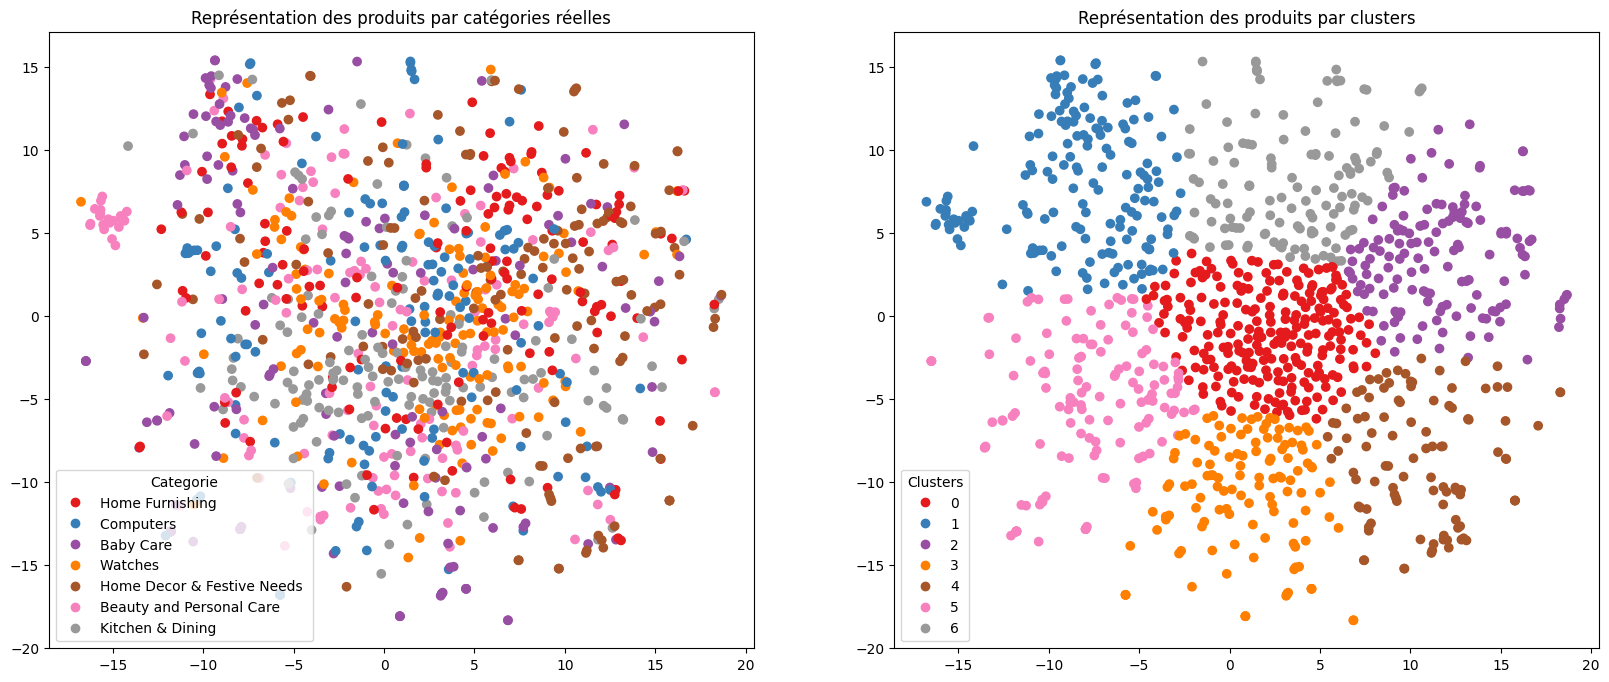

In [17]:
# TSNE + kmeans
X_reduc = reduction_fct(im_features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['catA'])
reduc_visu_fct(X_reduc, data['catA'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "TSNE", ARI]], axis=0)

In [18]:
from keras.applications import VGG16


VGG16_model = VGG16(weights="imagenet")

VGG16_model.summary()

2025-02-01 18:05:12.523909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Chargement des images et pre-processing spécifique

from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from PIL import Image, ImageOps
import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(IMAGE_DIR+data["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████| 1050/1050 [00:22<00:00, 46.29it/s]


In [21]:
# Utilisation du modèle pour générer les features

from keras.models import Model

VGG16_model = VGG16()

VGG16_model = Model(inputs=VGG16_model.inputs,
                    outputs=VGG16_model.layers[-2].output)

features = VGG16_model.predict(X, batch_size=32)


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_46']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


32/33 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_46']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step


In [22]:
# kmeans

ARI, labels = kmeans_fct(features, data["catA"])

ARI_results = np.append(ARI_results, [["VGG16", "None", ARI]], axis=0)

ARI :  0.3773


In [23]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data["catA"])

ARI_results = np.append(ARI_results, [["VGG16", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 824
ARI :  0.3773


ARI :  0.4399


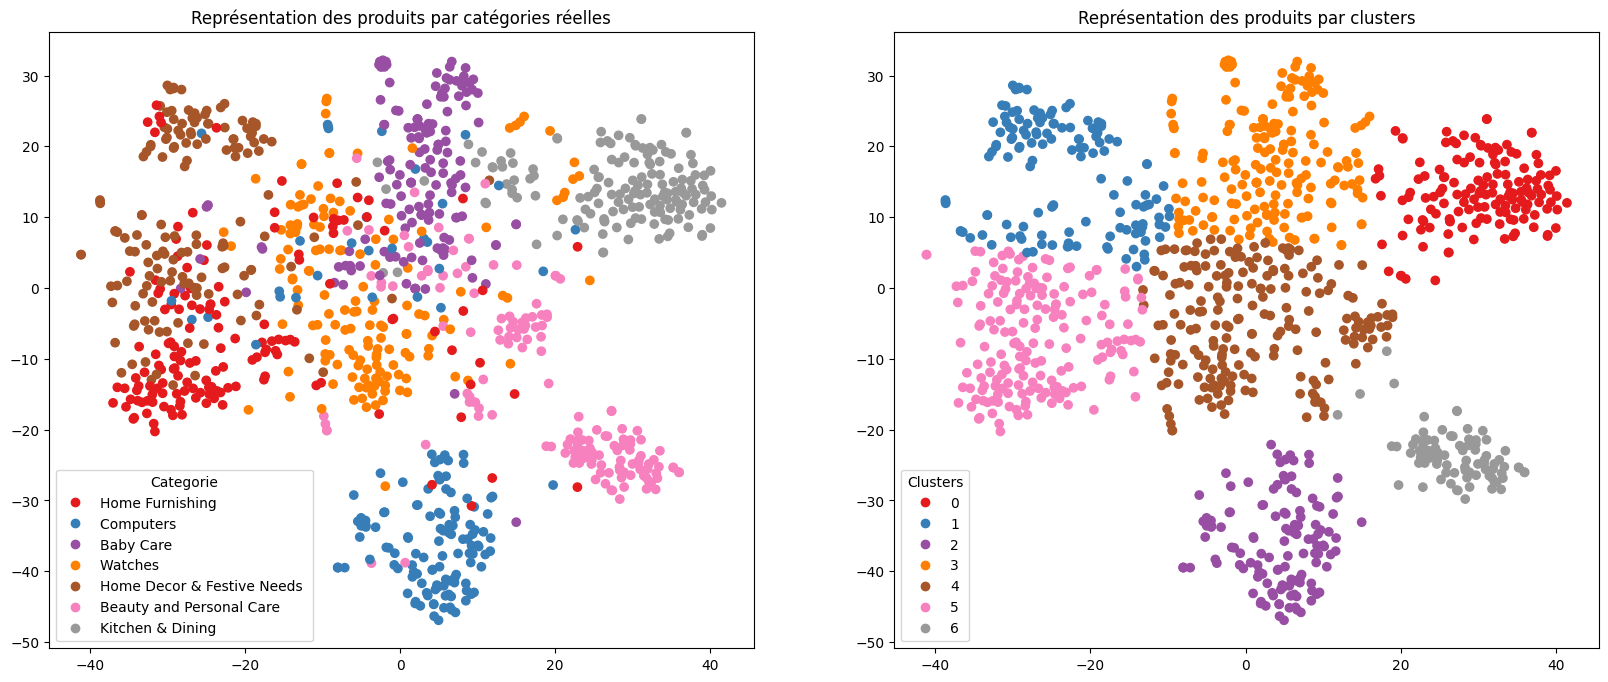

In [24]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"])
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["VGG16", "TSNE", ARI]], axis=0)

In [25]:
# Importation des bibliothèques
from keras.applications import EfficientNetB3
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm  # Pour afficher la barre de progression
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Initialisation du tableau X (images prétraitées)
X = []

# Parcours de toutes les images
for image_num in tqdm(range(len(list_photos))):
    # Charger l'image
    img = load_img(IMAGE_DIR + data["image"][image_num], target_size=(300, 300))  # EfficientNet attend du 300x300

    # Appliquer l'égalisation de l'histogramme
    img = ImageOps.equalize(img, mask=None)

    # Convertir en tableau NumPy
    img = np.array(img)

    # Reshape pour correspondre aux attentes du modèle
    reshaped_img = img.reshape(300, 300, 3)

    # Prétraitement spécifique à EfficientNet
    imgx = preprocess_input(reshaped_img)

    # Ajouter à la liste des images
    X.append(imgx)

# Convertir X en numpy array
X = np.array(X)

# Charger EfficientNetB3 pré-entraîné sur ImageNet
EfficientNetB3_model = EfficientNetB3(weights="imagenet")

# Modifier le modèle pour extraire les features de la dernière couche avant classification
EfficientNetB3_model = Model(inputs=EfficientNetB3_model.inputs,
                             outputs=EfficientNetB3_model.layers[-2].output)  # Avant la couche softmax

# Générer les features
features = EfficientNetB3_model.predict(X,  batch_size=32)

# Afficher la forme des features extraits
print("Features extraits (shape) :", features.shape)


100%|██████████| 1050/1050 [00:21<00:00, 49.18it/s]


50095040/50095040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_69']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)


32/33 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_69']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step
Features extraits (shape) : (1050, 1536)


In [26]:
# kmeans

ARI, labels = kmeans_fct(features, data["catA"])

ARI_results = np.append(ARI_results, [["EfficientNetB3", "None", ARI]], axis=0)

ARI :  0.4561


In [27]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data["catA"])

ARI_results = np.append(ARI_results, [["EfficientNetB3", "PCA", ARI]], axis=0)

Components before PCA: 1536
Components after PCA: 723
ARI :  0.5044


ARI :  0.5368


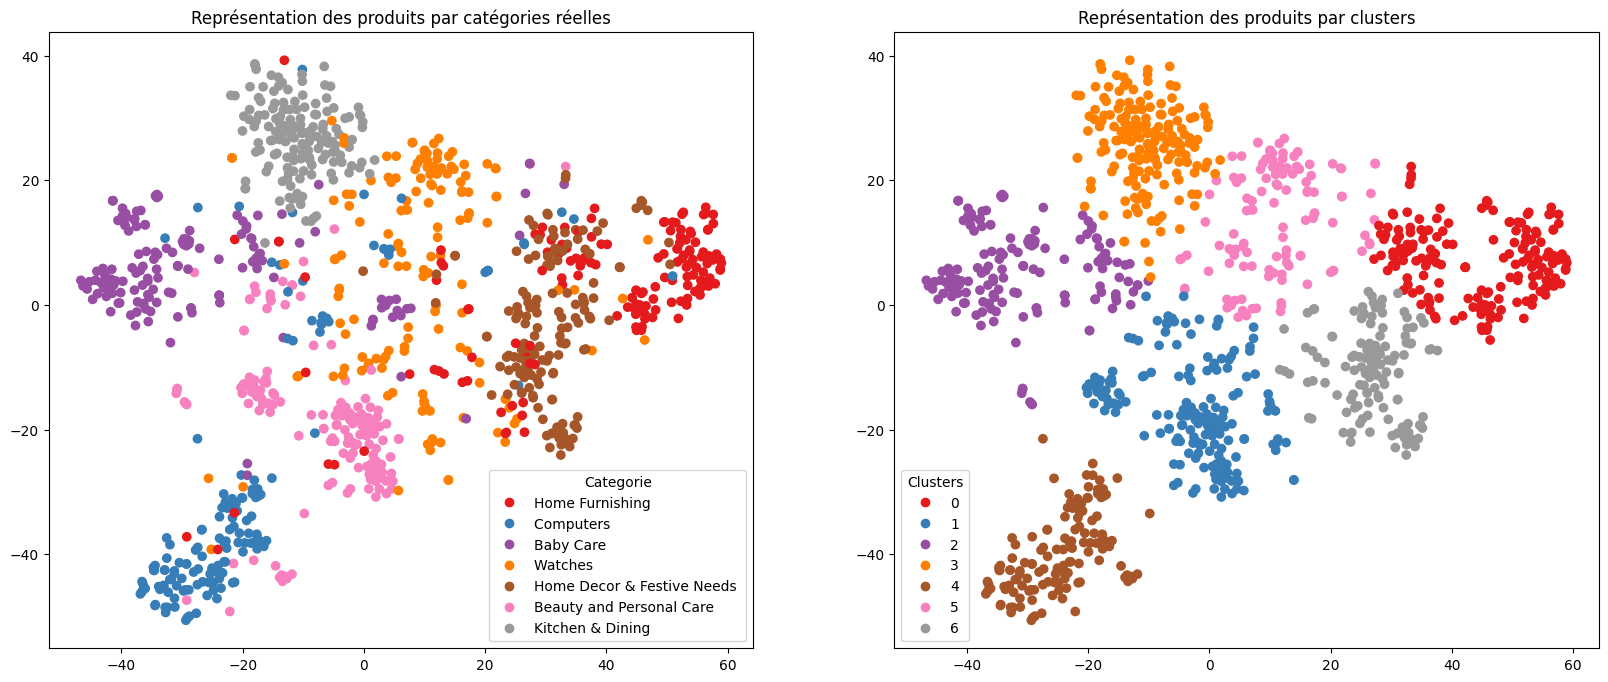

In [28]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"])
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["EfficientNetB3", "TSNE", ARI]], axis=0)

In [35]:
df_ari_results = pd.DataFrame(
    ARI_results, columns=["Modèle", "Réduction", "ARI"])
df_ari_results['ARI'] = df_ari_results['ARI'].astype(float)

In [36]:
df_ari_results

,Modèle,Réduction,ARI
0,SIFT,None,0.0271
1,SIFT,PCA,0.0277
2,SIFT,TSNE,0.0432
3,VGG16,None,0.3773
4,VGG16,PCA,0.3773
5,VGG16,TSNE,0.4399
6,EfficientNetB3,None,0.4561
7,EfficientNetB3,PCA,0.5044
8,EfficientNetB3,TSNE,0.5368


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


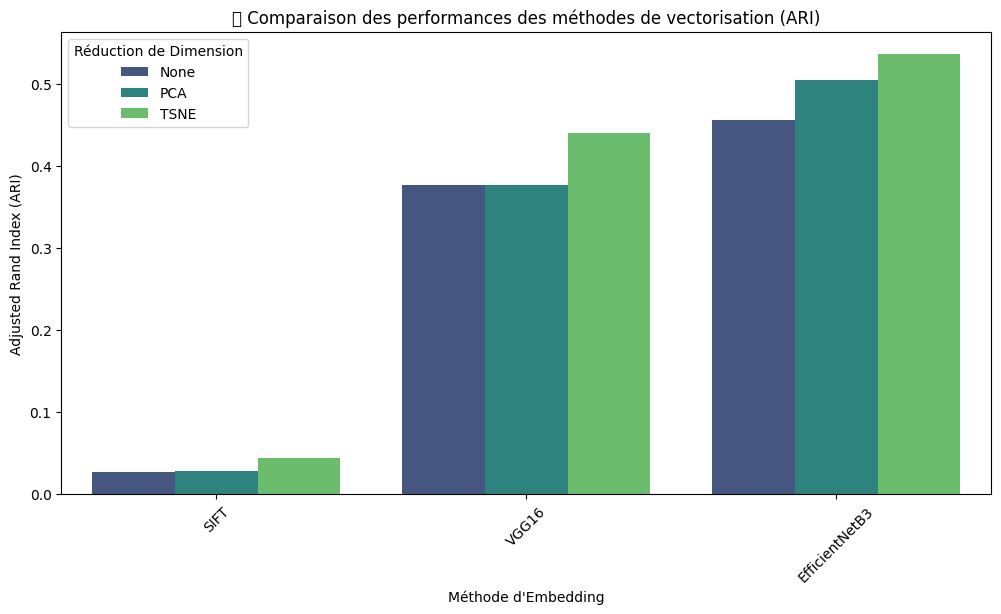

In [37]:
import seaborn as sns

# 📌 Visualisation des scores ARI
plt.figure(figsize=(12, 6))
sns.barplot(data=df_ari_results, x="Modèle", y="ARI", hue="Réduction", palette="viridis")

plt.ylabel("Adjusted Rand Index (ARI)")
plt.xlabel("Méthode d'Embedding")
plt.title("📊 Comparaison des performances des méthodes de vectorisation (ARI)")
plt.xticks(rotation=45)
plt.legend(title="Réduction de Dimension")

plt.show()

In [40]:
# Recréation des features du meilleur modèle
X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(IMAGE_DIR+data["image"][image_num], target_size=(300, 300))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(300, 300, 3)
    imgx = preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)


features = EfficientNetB3_model.predict(X,batch_size=32)

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['catA'])

100%|██████████| 1050/1050 [00:19<00:00, 52.80it/s]


33/33 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step
ARI :  0.5368


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


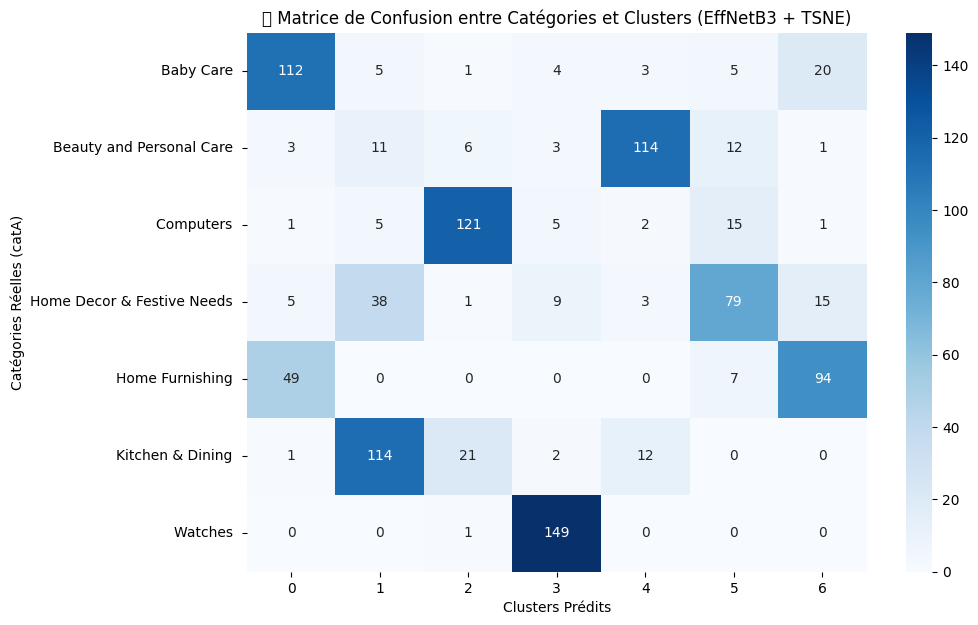

In [42]:
from sklearn.metrics import confusion_matrix

#  Conversion des labels réels en entiers
label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(data["catA"])  # Convertit les catégories en nombres

# Création de la Matrice de Confusion
conf_matrix = confusion_matrix(true_labels_numeric, labels)

# Affichage de la Matrice de Confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(labels), 
            yticklabels=label_encoder.classes_)  # Affichage des noms de catégories réelles

plt.xlabel("Clusters Prédits")
plt.ylabel("Catégories Réelles (catA)")
plt.title("📊 Matrice de Confusion entre Catégories et Clusters (EffNetB3 + TSNE)")
plt.show()